# Анализ столбца с данными о выходе продукта (таргет)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("df-predicting_the_reaction_output.csv")
product_yield_stats = df['Product_Yield_PCT_Area_UV'].describe()
print(product_yield_stats)

count    1008.000000
mean       18.213294
std        28.059151
min         0.000000
25%         0.000000
50%         4.000000
75%        24.000000
max        99.000000
Name: Product_Yield_PCT_Area_UV, dtype: float64


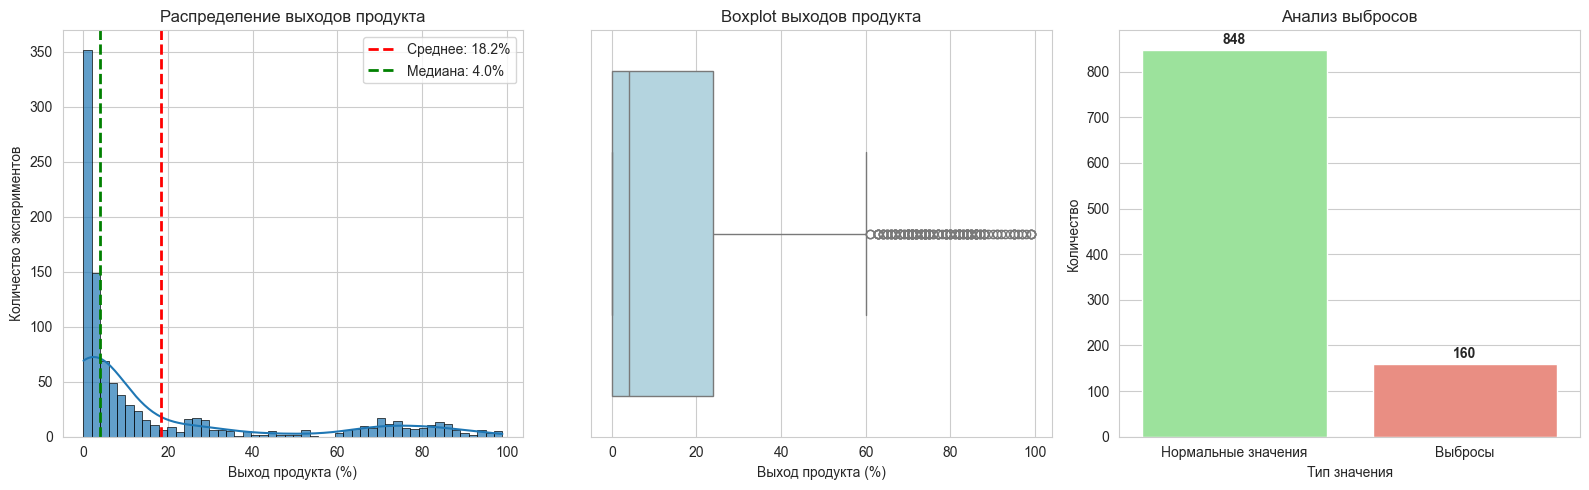

In [3]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.histplot(data=df, x='Product_Yield_PCT_Area_UV', bins=50, 
             edgecolor='black', alpha=0.7, kde=True)
plt.axvline(product_yield_stats['mean'], color='red', linestyle='--', linewidth=2, 
            label=f'Среднее: {product_yield_stats["mean"]:.1f}%')
plt.axvline(product_yield_stats['50%'], color='green', linestyle='--', linewidth=2, 
            label=f'Медиана: {product_yield_stats["50%"]:.1f}%')
plt.xlabel('Выход продукта (%)')
plt.ylabel('Количество экспериментов')
plt.title('Распределение выходов продукта')
plt.legend()

plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='Product_Yield_PCT_Area_UV', color='lightblue')
plt.xlabel('Выход продукта (%)')
plt.title('Boxplot выходов продукта')
plt.yticks([])

plt.subplot(1, 3, 3)
Q1 = df['Product_Yield_PCT_Area_UV'].quantile(0.25)
Q3 = df['Product_Yield_PCT_Area_UV'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Product_Yield_PCT_Area_UV'] < Q1 - 1.5*IQR) |
             (df['Product_Yield_PCT_Area_UV'] > Q3 + 1.5*IQR)]

outlier_data = pd.DataFrame({
    'Тип значения': ['Нормальные значения', 'Выбросы'],
    'Количество': [len(df) - len(outliers), len(outliers)]
})

sns.barplot(data=outlier_data, x='Тип значения', y='Количество', 
            hue='Тип значения', palette=['lightgreen', 'salmon'], legend=False)
plt.title('Анализ выбросов')

for i, value in enumerate(outlier_data['Количество']):
    plt.text(i, value + 5, str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Работа с датасетом (Удаление столбцов, в которых пропусков больше 80%)

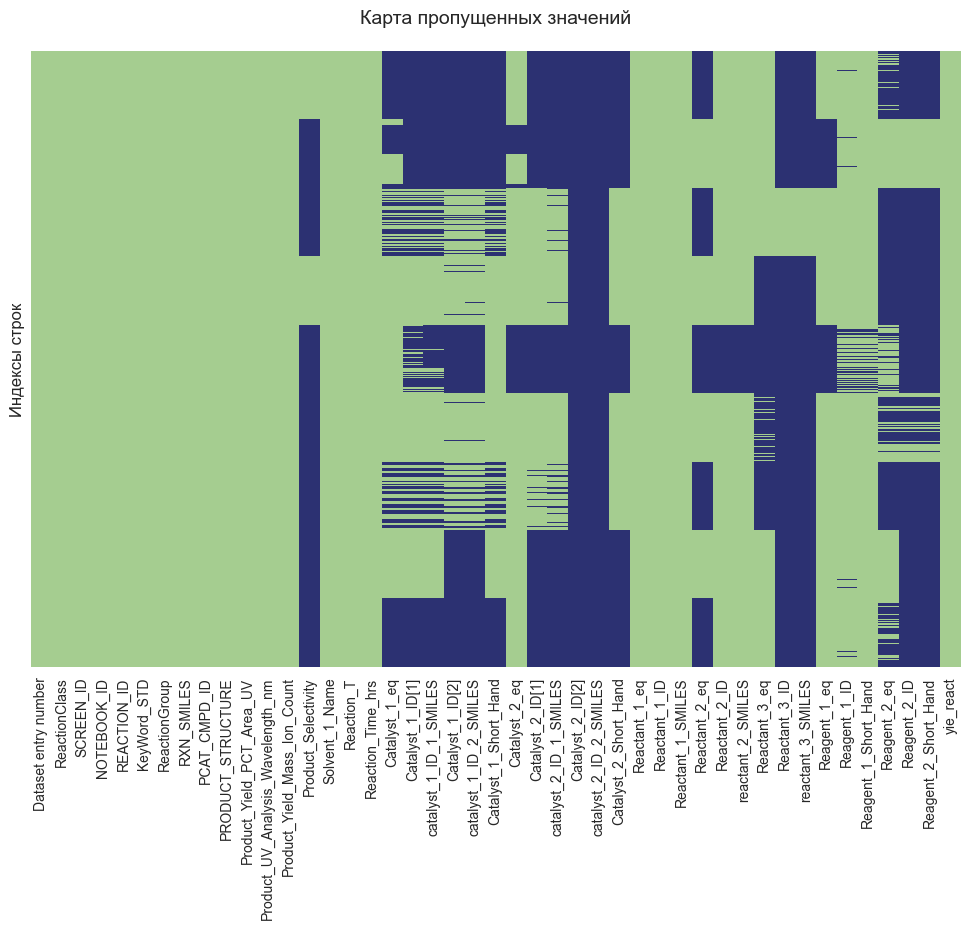

In [4]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='crest')
plt.title('Карта пропущенных значений', fontsize=14, pad=20)
plt.ylabel('Индексы строк', fontsize=12)
plt.show()

In [5]:
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df) * 100)

sorted_gaps = missing_data.sort_values(ascending=False)
sorted_percent = missing_percent.sort_values(ascending=False)

df_analysis = pd.DataFrame({
    'Столбец': sorted_gaps.index,
    'Количество_пропусков': sorted_gaps.values,
    'Процент_пропусков': sorted_percent.values.round(2)
})

df_analysis = df_analysis[df_analysis['Количество_пропусков'] > 0]

if not df_analysis.empty:
    styled_table = df_analysis.style.background_gradient(
        subset=['Процент_пропусков'], cmap='Blues'
    ).format({
        'Количество_пропусков': '{:,}',
        'Процент_пропусков': '{:.1f}%'
    })
    
    display(styled_table)

,Столбец,Количество_пропусков,Процент_пропусков
0,catalyst_2_ID_2_SMILES,"1,008",100.0%
1,Catalyst_2_ID[2],"1,008",100.0%
2,reactant_3_SMILES,896,88.9%
3,Reactant_3_ID,896,88.9%
4,Reagent_2_Short_Hand,844,83.7%
5,Reagent_2_ID,844,83.7%
6,Product_Selectivity,784,77.8%
7,catalyst_1_ID_2_SMILES,620,61.5%
8,Catalyst_1_ID[2],618,61.3%
9,catalyst_2_ID_1_SMILES,595,59.0%


# Удаление столбцов

### Количество уникальных значений по столбцам

In [6]:
unique_counts = df.nunique().sort_values(ascending=True)
total_rows = len(df)

unique_stats = pd.DataFrame({
    'Столбец': unique_counts.index,
    'Уникальные_значения': unique_counts.values,
    'Процент_уникальности': ((unique_counts / total_rows * 100).round(2)).values
})

if not unique_stats.empty:
    unique_stats = unique_stats.style.background_gradient(
        subset=['Процент_уникальности'], cmap='Blues'
    ).format({
        'Уникальные_значения': '{:,}',
        'Процент_уникальности': '{:.1f}%'
    })
display(unique_stats)

,Столбец,Уникальные_значения,Процент_уникальности
0,Catalyst_2_ID[2],0,0.0%
1,catalyst_2_ID_2_SMILES,0,0.0%
2,Reactant_1_eq,1,0.1%
3,reactant_3_SMILES,1,0.1%
4,Reaction_Time_hrs,1,0.1%
5,Reactant_3_ID,1,0.1%
6,Reagent_2_Short_Hand,2,0.2%
7,Reactant_2_eq,2,0.2%
8,Reagent_2_ID,2,0.2%
9,Product_UV_Analysis_Wavelength_nm,2,0.2%


In [7]:
cols_to_drop = [
    "yie_react", "Dataset entry number", "Product_Yield_Mass_Ion_Count", 
    "Product_Selectivity", "Reaction_Time_hrs", "reactant_3_SMILES", 
    "Reactant_3_ID", "Reactant_1_eq", "NOTEBOOK_ID", "SCREEN_ID", 
    "REACTION_ID", "KeyWord_STD", "catalyst_2_ID_2_SMILES", "Catalyst_2_ID[2]"
]

df_clean = df.drop(columns=cols_to_drop, errors='ignore')
df = df_clean.copy()
print(f"Удалено столбцов: {len(cols_to_drop)}")
print(f"Размер датафрейма после очистки: {df.shape}")

Удалено столбцов: 14
Размер датафрейма после очистки: (1008, 31)


In [8]:
df.to_csv('df_cleared.csv', index=False)

### Корреляция Спирмана для числовых признаков

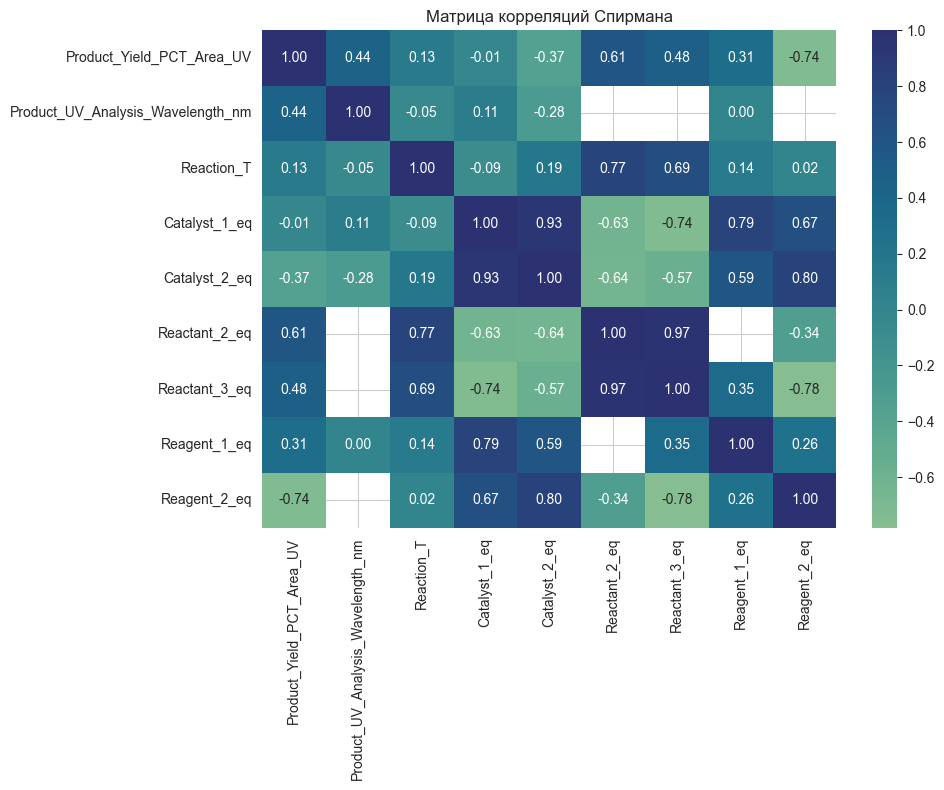

Корреляция Спирмана с выходом продукта:
Product_Yield_PCT_Area_UV            1.000000
Reactant_2_eq                        0.609285
Reactant_3_eq                        0.479582
Product_UV_Analysis_Wavelength_nm    0.437851
Reagent_1_eq                         0.307770
Reaction_T                           0.125219
Catalyst_1_eq                       -0.014772
Catalyst_2_eq                       -0.367505
Reagent_2_eq                        -0.735551
Name: Product_Yield_PCT_Area_UV, dtype: float64


In [9]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

numeric_df = df_clean.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr(method='spearman')

sns.heatmap(correlation_matrix, annot=True, cmap='crest', center=0, fmt='.2f')
plt.title('Матрица корреляций Спирмана')
plt.tight_layout()
plt.show()

target_corr = correlation_matrix['Product_Yield_PCT_Area_UV'].sort_values(ascending=False)
print("Корреляция Спирмана с выходом продукта:")
print(target_corr)